<a href="https://colab.research.google.com/github/NikitaSavvin2000/CNN-LSTM/blob/main/lstm_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
# Загрузка данных
# Предполагается, что у вас есть DataFrame df_Pl с колонками "time" и "P_l"
# "time" содержит временной ряд в формате 'yyyy-mm-dd hh-mm-ss'
# "P_l" содержит значения энергопотребления

df_Pl = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRKJzXJlQSNew0dxrQ8mFQMhBv_4owvfsF2If1b-rmxMZkR5gabHC4OiaSwt8Ul1Omc8taR27UohSeg/pub?gid=429486365&single=true&output=csv')
nan_indices = df_Pl.index[df_Pl['P_l'].isna()]
avg_pl = df_Pl['P_l'].mean()

df_Pl['P_l'].fillna(avg_pl, inplace=True)


# Преобразование времени в формат datetime
df_Pl['time'] = pd.to_datetime(df_Pl['time'])

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
df_Pl['Scaled_P_l'] = scaler.fit_transform(df_Pl['P_l'].values.reshape(-1, 1))
print()
# Создание временных последовательностей
look_back = 10  # можно изменить в зависимости от требований
X, y = [], []

for i in tqdm(range(len(df_Pl) - look_back)):
    X.append(df_Pl[['Scaled_P_l', 'time']][i:(i + look_back)].values)
    y.append(df_Pl['Scaled_P_l'][i + look_back])

X, y = np.array(X), np.array(y)




100%|██████████| 762881/762881 [46:52<00:00, 271.25it/s]


In [ ]:
from tensorflow.keras.layers import Input, concatenate, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
import numpy as np

# Разделение на обучающий и тестовый наборы
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Преобразование данных в формат, подходящий для LSTM и CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

# Создание входов
input_cnn = Input(shape=(X_train.shape[1], 1), name='input_cnn')
input_lstm = Input(shape=(X_train.shape[1], 1), name='input_lstm')

# Сверточный слой для признака P_l
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input_cnn)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)

# Вход для времени
flat2 = Flatten()(input_lstm)

# Объединение выходов сверточного слоя и выходов для времени
merged = concatenate([flat1, flat2])

# Полносвязный слой
dense = Dense(units=50, activation='relu')(merged)

# Выходной слой
output = Dense(units=1, activation='linear')(dense)

# Создание и обучение модели
model = Model(inputs=[input_cnn, input_lstm], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

X_train_cnn = X_train[:, :, 0:1].astype('float32')
X_train_lstm = np.vectorize(lambda x: x.timestamp())(X_train[:, :, 1]).astype('float32')
model.fit([X_train_cnn, X_train_lstm], y_train, epochs=100, batch_size=32)


In [27]:
from google.colab import drive


# Подключение Google Drive
drive.mount('/content/gdrive')
# Путь к Google Drive
google_drive_path = '/content/gdrive/MyDrive/'

# Сохранение модели
model.save(google_drive_path + 'your_model_0.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
def predict_energy_consumption(dates_to_predict, model, df_Pl, scaler, look_back):
    # Преобразование входных дат в формат datetime
    dates_to_predict = pd.to_datetime(dates_to_predict)

    # Установка временной зоны для dates_to_predict, если она отсутствует
    if dates_to_predict.tzinfo is None:
        dates_to_predict = dates_to_predict.tz_localize(df_Pl['time'].dt.tz)

    # Создание временных последовательностей для прогноза
    X_predict = []

    for date in dates_to_predict:
        # Получение последних look_back точек для каждой даты
        X_predict.append(df_Pl[df_Pl['time'] <= date].tail(look_back)[['Scaled_P_l', 'time']].values)

    X_predict = np.array(X_predict)

    # Преобразование данных в формат, подходящий для LSTM
    min_time = df_Pl['time'].min().timestamp()
    max_time = df_Pl['time'].max().timestamp()

    X_predict[:,:,1] = (X_predict[:,:,1].astype('datetime64[s]').view('int64') - min_time) / (max_time - min_time)

    # Предсказание энергопотребления
    predicted_scaled_values = model.predict(X_predict.astype('float32'))  # Convert to float32

    # Инвертирование нормализации для получения итоговых прогнозов
    predicted_values = scaler.inverse_transform(predicted_scaled_values)

    # Создание DataFrame с прогнозами
    df_predict = pd.DataFrame({'time': dates_to_predict, 'P_l': predicted_values.flatten()})

    return df_predict


In [56]:
def predict_energy_consumption(dates_to_predict, model, df_Pl, scaler, look_back):
    # Преобразование входных дат в формат datetime
    dates_to_predict = pd.to_datetime(dates_to_predict)

    # Установка временной зоны для dates_to_predict, если она отсутствует
    if dates_to_predict.tzinfo is None:
        dates_to_predict = dates_to_predict.tz_localize(df_Pl['time'].dt.tz)

    # Создание временных последовательностей для прогноза
    X_predict_cnn = []
    X_predict_lstm = []

    for date in dates_to_predict:
        # Получение последних look_back точек для каждой даты
        X_predict_cnn.append(df_Pl[df_Pl['time'] <= date].tail(look_back)[['Scaled_P_l']].values)
        X_predict_lstm.append(df_Pl[df_Pl['time'] <= date].tail(look_back)[['time']].values)

    X_predict_cnn = np.array(X_predict_cnn)
    X_predict_lstm = np.array(X_predict_lstm)

    # Преобразование данных в формат, подходящий для LSTM и CNN
    X_predict_cnn = np.reshape(X_predict_cnn, (X_predict_cnn.shape[0], X_predict_cnn.shape[1], 1))
    X_predict_lstm[:,:,0] = (X_predict_lstm[:,:,0].astype('datetime64[s]').view('int64') - df_Pl['time'].min().timestamp()) / (df_Pl['time'].max().timestamp() - df_Pl['time'].min().timestamp())

    # Предсказание энергопотребления
    predicted_scaled_values = model.predict([X_predict_cnn.astype('float32'), X_predict_lstm.astype('float32')])

    # Инвертирование нормализации для получения итоговых прогнозов
    predicted_values = scaler.inverse_transform(predicted_scaled_values)

    # Создание DataFrame с прогнозами
    df_predict = pd.DataFrame({'time': dates_to_predict, 'P_l': predicted_values.flatten()})

    return df_predict


<ipython-input-56-9a7794c5f66d>:23: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  X_predict_lstm[:,:,0] = (X_predict_lstm[:,:,0].astype('datetime64[s]').view('int64') - df_Pl['time'].min().timestamp()) / (df_Pl['time'].max().timestamp() - df_Pl['time'].min().timestamp())


82/82 [==============================] - 0s 2ms/step
                          time           P_l
0    2023-09-01 00:00:00+00:00  26994.341797
1    2023-09-01 00:05:00+00:00  26994.341797
2    2023-09-01 00:10:00+00:00  26994.341797
3    2023-09-01 00:15:00+00:00  26994.341797
4    2023-09-01 00:20:00+00:00  26994.341797
...                        ...           ...
2588 2023-09-09 23:40:00+00:00  26994.341797
2589 2023-09-09 23:45:00+00:00  26994.341797
2590 2023-09-09 23:50:00+00:00  26994.341797
2591 2023-09-09 23:55:00+00:00  26994.341797
2592 2023-09-10 00:00:00+00:00  26994.341797

[2593 rows x 2 columns]


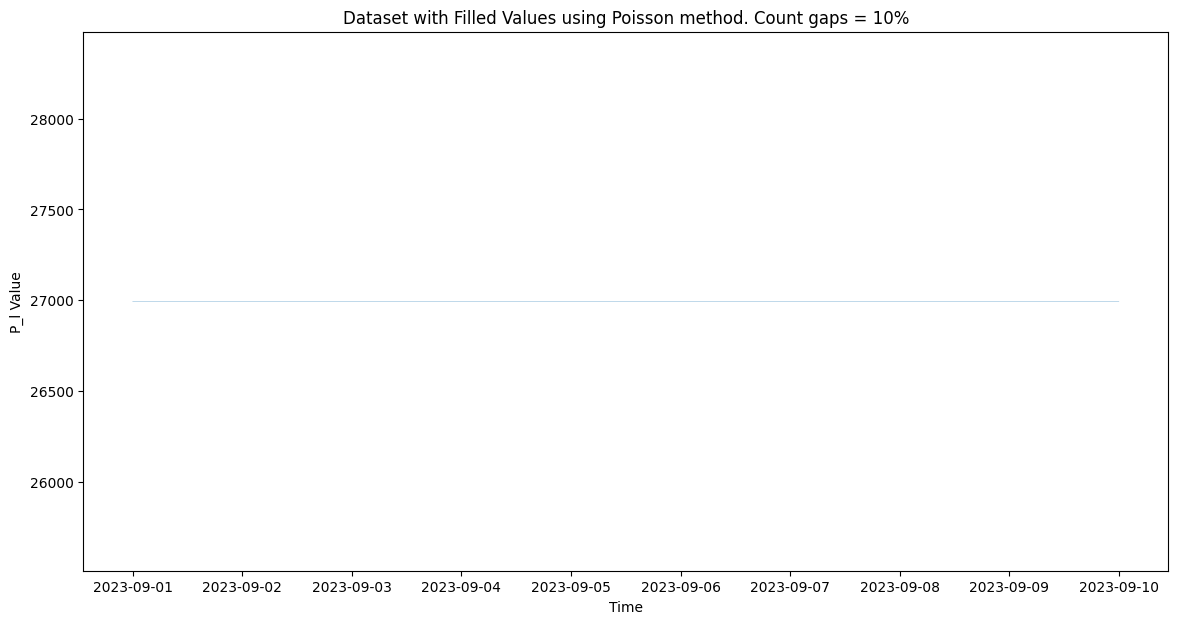

In [57]:
# Функция для прогнозирования
# Пример использования функции для прогнозирования
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import load_model

# Приведение временных меток из pd.date_range к типу Timestamp
dates_to_predict = pd.date_range(start='2023-09-01', end='2023-09-10', freq='5T')
dates_to_predict = pd.to_datetime(dates_to_predict)

# Замените 'your_model_path' на путь к вашей модели
# Путь к модели в Google Drive
google_drive_path = '/content/gdrive/MyDrive/'
model_path = google_drive_path + 'your_model_0.h5'

# Загрузка модели
model =  load_model(model_path)

# Замените параметры на свои значения
predicted_df = predict_energy_consumption(dates_to_predict, model, df_Pl, scaler, look_back)

# Вывод результатов
print(predicted_df)

plt.figure(figsize=(14, 7))
plt.plot(predicted_df['time'], predicted_df['P_l'], linewidth=0.2)
plt.title(label="Dataset with Filled Values using Poisson method. Count gaps = 10%")
plt.ylabel("P_l Value")
plt.xlabel("Time")
plt.show()
